In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.dirname(sys.path[0]))
sys.path.append(PROJECT_ROOT)

from lsr_tensor import *
from lsr_bcd_regression import *
import torch
import torch.nn.functional as f
from datasets import *
from federated_algos import *
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from federated_tests import *
from medmnist import BreastMNIST
import cProfile
from torchvision import transforms

/home/fishcat/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Synthetic Data
shape, ranks, separation_rank = (32, 32, 32), (4, 4, 4), 2
loss_fn = f.mse_loss

sample_size = 2000
val_sample_size = 500

synth_dataset, synth_val_dataset = synthesize_data(shape, ranks, separation_rank,\
                                                   sample_size, val_sample_size)
synth_client_datasets = federate_dataset(synth_dataset, 5)
synth_data = (synth_dataset, synth_client_datasets, synth_val_dataset)

In [ ]:
# Breast MNIST
shape, ranks, separation_rank = (28, 28), (3, 3), 2
loss_fn = logistic_loss

transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32)])

breast_dataset = BreastMNIST(split="train", download=True, transform=transform)
breast_client_datasets = federate_dataset(breast_dataset, 5)
breast_val_dataset = BreastMNIST(split="val", download=True, transform=transform)
breast_data = (breast_dataset, breast_client_datasets, breast_val_dataset)

In [ ]:
print("Testing...")

hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cpu'))

init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
lsr_bcd_regression(init_lsr_dot, loss_fn, synth_dataset, synth_val_dataset,\
                       hypers, True)

print("Finished without errors")

In [5]:
iters = 1000
n_workers = 5
n_runs = 1

dataset, client_datasets, val_dataset = synth_data
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
hypers = {"max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}

lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cpu'))

print("Centralized algorithm training")
init_lsr_dot = LSR_tensor_dot(shape, ranks, separation_rank)
args = (lsr_bcd_regression, lsr_dot_params, loss_fn, dataset, val_dataset, hypers, False)

unfed_loss, unfed_error = run_test(n_runs, n_workers, *args)

print("\nStepwise federated algorithm training...")
args = (BCD_federated_stepwise, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

step_loss, step_error = run_test(n_runs, n_workers, *args)

print("\nSplit factors + core federated algorithm training...")
args = (BCD_federated_all_factors, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False, True)

fact_loss, fact_error = run_test(n_runs, n_workers, *args)

print("\n1 full iteration federated algorithm training...")
hypers["max_rounds"], hypers["max_iter"] = iters, 1
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

full1_loss, full1_error = run_test(n_runs, n_workers, *args)

print("\n5 full iteration federated algorithm training...")
hypers["max_rounds"], hypers["max_iter"] = iters // 5, 5
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

full5_loss, full5_error = run_test(n_runs, n_workers, *args)

Centralized algorithm training
Run 0



KeyboardInterrupt



In [ ]:
#Save data from runs
total_runs = n_workers * n_runs
tensors = {f"unfed": (unfed_loss, unfed_error), f"step": (step_loss, step_error),\
           f"factors_core": (fact_loss, fact_error), f"full_1": (full1_loss, full1_error),\ 
           f"full_5": (full5_loss, full5_loss)}

for name in tensors:  
    loss_name = f"{name}_loss_n{total_runs}"
    error_name = f"{name}_error_n{total_runs}"
    
    torch.save(tensors[name], "../data/" + loss_name + ".pt")
    torch.save(tensors[name], "../data/" + error_name + ".pt")
    
print("Saved run data")

In [ ]:
#Load data from runs
total_runs = 40
tensors = [f"unfed", f"step", f"factors_core", f"full_1", f"full_5"]

for name in tensors:
    loss_name = f"{name}_loss_n{total_runs}"
    error_name = f"{name}_error_n{total_runs}"
    
    torch.save("../data/" + loss_name + ".pt")
    torch.save("../data/" + error_name + ".pt")
    
print("Loaded run data")

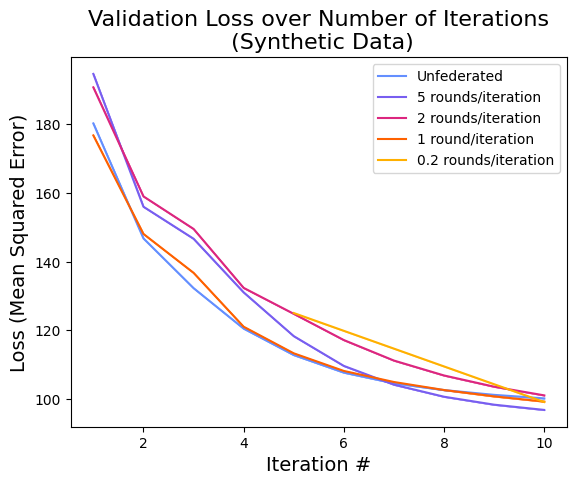

In [4]:
plt.plot(np.arange(len(unfed_loss)) + 1, unfed_loss, label="Unfederated", color="#648FFF")
plt.fill_between(np.arange(len(unfed_loss)) + 1, unfed_loss-unfed_error, unfed_loss+unfed_error, color="#648FFF", alpha=0.5)

plt.plot(np.arange(len(step_loss)) + 1, step_loss, label="5 rounds/iteration", color="#785EF0")
plt.fill_between(np.arange(len(step_loss)) + 1, step_loss-step_error, step_loss+step_error, color="#785EF0", alpha=0.5)

plt.plot(np.arange(len(fact_loss)) + 1, fact_loss, label="2 rounds/iteration", color="#DC267F")
plt.fill_between(np.arange(len(fact_loss)) + 1, fact_loss-fact_error, fact_loss+fact_error, color="#DC267F", alpha=0.5)

plt.plot(np.arange(len(full1_loss)) + 1, full1_loss, label="1 round/iteration", color="#FE6100")
plt.fill_between(np.arange(len(full1_loss)) + 1, full1_loss-full1_error, full1_loss+full1_error, color="#FE6100", alpha=0.5)

plt.plot((np.arange(len(full5_loss)) + 1)*5, full5_loss, label="0.2 rounds/iteration", color="#FFB000")
plt.fill_between((np.arange(len(full5_loss)) + 1)*5, full5_loss-full5_error, full5_loss+full5_error, color="#FFB000", alpha=0.5)
plt.legend()
plt.xlabel("Iteration #", fontsize=14)
plt.ylabel("Loss (Mean Squared Error)", fontsize=14)
plt.title("Validation Loss over Number of Iterations\n (Synthetic Data)", fontsize=16)
plt.show()

In [ ]:
# Performance testing
print("Performance Testing...")
hypers = {"max_rounds": 1, "max_iter": 5, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cpu'))
init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
cProfile.run("lsr_bcd_regression(init_lsr_dot, loss_fn, synth_dataset, synth_val_dataset,\
                       hypers, True)", sort='tottime')